# Political Alignment Case Study

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)


### Introduction

This notebook is a template for a do-it-yourself, choose-your-own-adventure mini-project that explores the relationship between political alignment and other attitudes and beliefs.

I will outline the steps and provide sample code.  You can choose which survey question to explore, adapt my code for your data, and write a report presenting the results.

In previous notebooks, we looked at changes in political alignment over time, and explored the relationship between political alignment and survey questions related to "outlook".

The analysis in this notebook follows the steps we have seen:

1) For your variable of interest, you will read the code book to understand the question and valid responses.

2) You will compute and display the distribution (PMF) of responses and the distribution within each political group.

3) You will recode the variable on a numerical scale that makes it possible to interpret the mean, and then plot the mean over time.

4) You will use a pivot table to compute the mean of your variable over time for each political alignment group (liberal, moderate, and conservative).

5) Finally, you will look at results from three resamplings of the data to see whether the patterns you observed might be due to random sampling.

### Setup

If you are running this notebook in Colab, the following cell installs the `empiricaldist` library.

If you are running in another environment, you will need to install it yourself.

In [7]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

If everything we need is installed, the following cell should run without error.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

The following cells define functions from previous notebooks we will use again.

In [9]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

In [10]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [12]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

In [13]:
def plot_columns_lowess(table, columns, color_map):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    color_map: mapping from column names to color_map
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, color_map[col])

### Loading the data

In the first notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF5 file, which is much faster to load.

The following cells downloads the file.

In [14]:
# Load the data file

import os

datafile = 'gss_eda.3.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.3.hdf5


Now I'll load one of the resampled DataFrames.

In [15]:
gss = pd.read_hdf(datafile, 'gss0')
gss.shape

(64814, 165)

## Changes in social attitudes

The General Social Survey includes questions about a variety of social attitudes and beliefs.  We can use this dataset to explore changes in the responses over time and the relationship with political alignment.

In my subset of the GSS data, I selected questions that were asked repeatedly over the interval of the survey.  [You can see the variables I chose on the GSS web site](https://gssdataexplorer.norc.org/projects/52787/variables/data_cart).

To do the exercises in this notebook, you should choose a variable that you think might be interesting.

I will walk you through a process for exploring the variable you choose, but you should feel free to ignore my suggestions if you have a better idea.

If you are not sure which variable to explore, here is a [random selection of three that you can choose from](https://en.wikipedia.org/wiki/The_Paradox_of_Choice):

In [16]:
cols = list(gss.columns)
for col in ['ballot', 'id_', 'year']:
    cols.remove(col)
    
np.random.shuffle(cols)
for col in cols[:3]:
    print(col)

class_
satjob
hunt



## Attitudes about homosexuality

As my example, I will look at responses to the following [question related to attitudes about homosexuality](https://gssdataexplorer.norc.org/projects/52787/variables/634/vshow).

> What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

The valid responses are:

```
1	Always wrong
2	Almost always wrong
3	Sometimes wrong
4	Not wrong at all
```

When you modify this notebook, you should replace this variable with the one you chose.

Here's the distribution of responses:

In [17]:
values(gss['homosex'])

1.0    23545
2.0     1678
3.0     2586
4.0     9863
Name: homosex, dtype: int64

And here's what the distribution looks like.

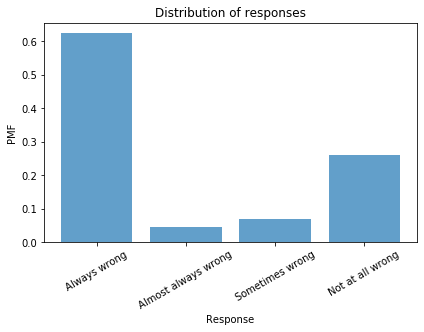

In [18]:
pmf = Pmf.from_seq(gss['homosex'])
pmf.bar(alpha=0.7)

decorate(xlabel='Response',
         ylabel='PMF',
         title='Distribution of responses')

responses = [1, 2, 3, 4]

labels = ['Always wrong',
          'Almost always wrong',
          'Sometimes wrong',
          'Not at all wrong']

plt.xticks(responses, labels, rotation=30);

When you write your report, you should add a few sentences here to interpret the results you get for your variable.

But remember that the results are an average over the entire interval of the survey, so you should not interpet it as a current condition.

## Responses over time

If we make a cross tabulation of `year` and the variable of interest, we get the distribution of responses over time.

In [19]:
xtab = pd.crosstab(gss['year'], gss['homosex'], normalize='index')
xtab.head()

homosex,1.0,2.0,3.0,4.0
year,,,,
1973,0.740977,0.058740,0.084926,0.115357
1974,0.741746,0.049156,0.077036,0.132062
1976,0.679806,0.057400,0.089212,0.173582
1977,0.729767,0.062414,0.071331,0.136488
1980,0.725772,0.055994,0.058148,0.160086


In [20]:
xtab.tail()

homosex,1.0,2.0,3.0,4.0
year,,,,
2010,0.474838,0.033279,0.077922,0.413961
2012,0.449878,0.029340,0.075795,0.444988
2014,0.388069,0.029520,0.077491,0.504920
2016,0.379444,0.036667,0.075000,0.508889
2018,0.332471,0.034282,0.057568,0.575679


Now we can plot the results.

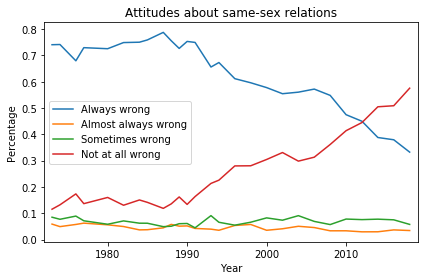

In [21]:
for response, label in zip(responses, labels):
    xtab[response].plot(label=label)

decorate(xlabel='Year',
         ylabel='Percentage',
         xlim=[1972, 2019],
         title='Attitudes about same-sex relations')

plt.legend();

When you write your report, you should add a few sentences here to interpret the results you get for your variable.

## Political alignment

To explore the relationship between this variable and political alignment, I'll recode political alignment into three groups:

In [22]:
d_polviews = {1: 'Liberal', 
              2: 'Liberal', 
              3: 'Liberal', 
              4: 'Moderate', 
              5: 'Conservative', 
              6: 'Conservative', 
              7: 'Conservative'}

I'll use `replace`, as we've seen before, and store the result as a new column in the DataFrame.

In [23]:
gss['polviews3'] = gss['polviews'].replace(d_polviews)

With this scale, there are roughly the same number of people in each group.

In [24]:
values(gss['polviews3'])

Conservative    19129
Liberal         14979
Moderate        21444
Name: polviews3, dtype: int64

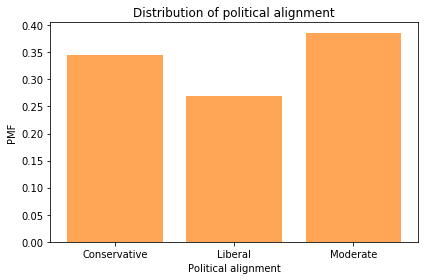

In [25]:
pmf = Pmf.from_seq(gss['polviews3'])
pmf.bar(color='C1', alpha=0.7)

decorate(xlabel='Political alignment',
         ylabel='PMF',
         title='Distribution of political alignment')

## Group by political alignment

Now we can use `groupby` to group the respondents by political alignment.

In [26]:
by_polviews = gss.groupby('polviews3')

Next I will plot the distribution of responses in each group.

But first I'll make a dictionary that maps from each group to a color.

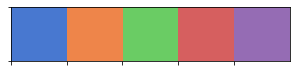

In [27]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [28]:
color_map = {'Conservative': muted[3], 
              'Moderate': muted[4], 
               'Liberal': muted[0]}

Now I'll make a PMF of responses for each group.

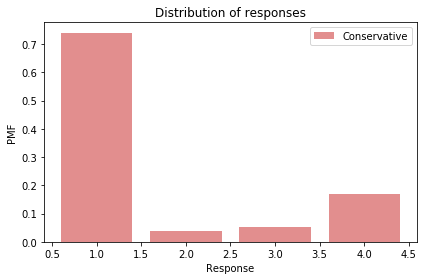

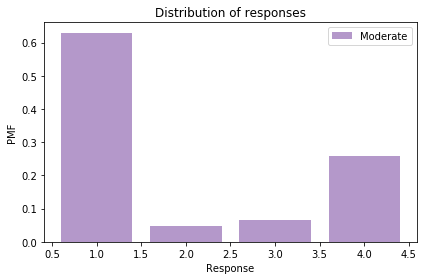

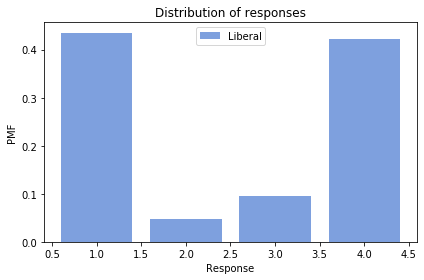

In [29]:
for name in color_map:
    group = by_polviews.get_group(name)
    
    plt.figure()
    pmf = Pmf.from_seq(group['homosex'])
    pmf.bar(label=name, color=color_map[name], alpha=0.7)
    
    decorate(xlabel='Response',
             ylabel='PMF',
             title='Distribution of responses')
    
    plt.legend()

When you write your report, you should add a few sentences here to interpret the results.

But again, the results are an average over the entire interval of the survey, so you should not interpet it as a current condition.

## Recode

For each group, we could compute the mean of the responses, but it would be hard to interpret. So we'll recode the variable of interest to make the mean more... meaningful.

For the variable I chose, a majority of respondents chose "always wrong".  I'll use that as my baseline response with code 1, and lump the other responses with code 0.

In [30]:
d_recode = {1:1, 2:0, 3:0, 4:0}

We can use `replace` to recode the values and store the result as a new column in the DataFrame.

In [31]:
gss['recoded'] = gss['homosex'].replace(d_recode)

And we'll use `values` to check whether it worked.

In [32]:
values(gss['recoded'])

0.0    14127
1.0    23545
Name: recoded, dtype: int64

Now if we compute the mean, we can interpret it as "the fraction of respondents who think same-sex sexual relations are always wrong".

In [33]:
gss['recoded'].mean()

0.625

## Average by group



Now we can compute the mean of the recoded variable in each group.

In [34]:
means = by_polviews['recoded'].mean()
means

polviews3
Conservative    0.740192
Liberal         0.435024
Moderate        0.629199
Name: recoded, dtype: float32

To get the values in a particular order, we can use the group names as an index:

In [35]:
names = color_map.keys()
names

dict_keys(['Conservative', 'Moderate', 'Liberal'])

In [36]:
means[names]

polviews3
Conservative    0.740192
Moderate        0.629199
Liberal         0.435024
Name: recoded, dtype: float32

Now we can make a bar plot with color-coded bars:

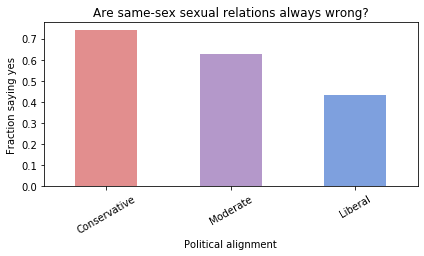

In [37]:
colors = color_map.values()

means[names].plot(kind='bar', color=colors, alpha=0.7)

decorate(xlabel='Political alignment',
         ylabel='Fraction saying yes',
         title='Are same-sex sexual relations always wrong?')

plt.xticks(rotation='30');

When you write your report, you should add a few sentences here to interpret the results you get for your variable.

## Time series

As we saw in previous notebooks, we can use `groupby` to group responses by year.

In [38]:
by_year = gss.groupby('year')

From the result we can select the recoded variable and compute the mean.

In [39]:
time_series = by_year['recoded'].mean()

And we can plot the results with the data points themselves as circles and a local regression model as a line.

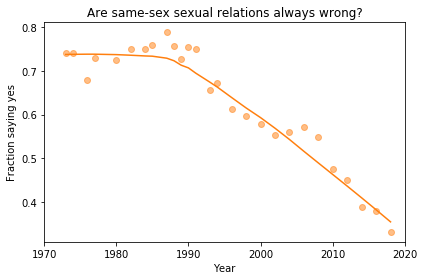

In [40]:
plot_series_lowess(time_series, 'C1')

decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1970, 2020],
         title='Are same-sex sexual relations always wrong?')

Again, you should add some text here to interpret the results you get for your variable.

## Time series by group

So far, we have grouped by `polviews3` and computed the mean of the variable of interest in each group.

Then we grouped by `year` and computed the mean for each year.

Now we'll use `pivot_table` to compute the mean in each group for each year.

In [41]:
table = gss.pivot_table(values='recoded', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

The result is a table that has years running down the rows and political alignment running across the columns.

Each entry in the table is the mean of the variable of interest for a given group in a given year.

In [42]:
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,0.825758,0.584577,0.790837
1976,0.775000,0.489848,0.716698
1977,0.823666,0.564165,0.769772
1980,0.834906,0.539130,0.740171
1982,0.801126,0.599198,0.811820


## Plotting the results

Now we can use `plot_columns_lowess` to see the results.

In [43]:
columns = ['Conservative', 'Moderate', 'Liberal']

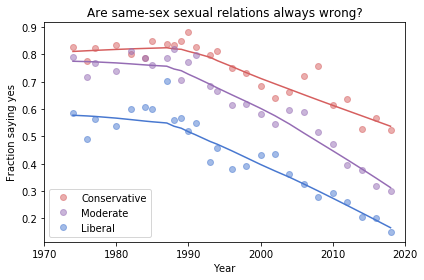

In [47]:
plot_columns_lowess(table, columns, color_map)

decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1970, 2020],
         title='Are same-sex sexual relations always wrong?')

plt.legend();

You should write a few sentences here to interpret the results.

## Resampling

The figures we have generated so far in this notebook are based on a single resampling of the GSS data.  Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.

By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.

To make that easier, the following function contains the code from the previous analysis all in one place.

You will probably have to update this function with any changes you made in my code.

In [45]:
def plot_by_polviews(gss):
    """Plot mean response by polviews and year.
    
    gss: DataFrame
    """
    gss['polviews3'] = gss['polviews'].replace(d_polviews)
    gss['recoded'] = gss['homosex'].replace(d_recode)
    
    table = gss.pivot_table(values='recoded', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

    plot_columns_lowess(table, columns, color_map)

    decorate(xlabel='Year',
             ylabel='Fraction saying yes',
             xlim=[1970, 2020],
             title='Are same-sex relations always wrong?')

Now we can loop through the three resampled datasets in the HDF5 file and generate a figure for each one.

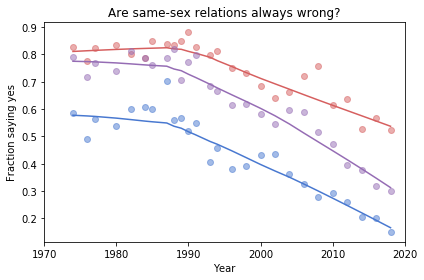

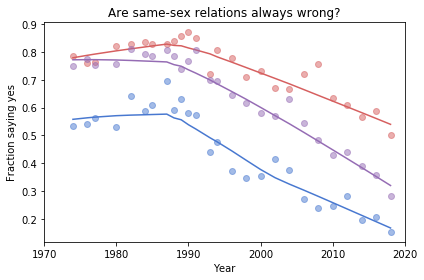

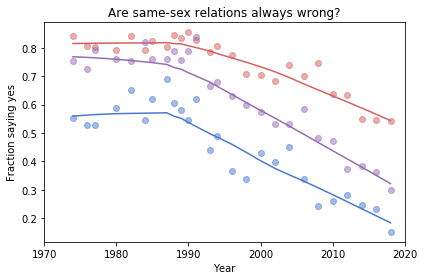

In [46]:
for key in ['gss0', 'gss1', 'gss2']:
    df = pd.read_hdf('gss_eda.3.hdf5', key)

    plt.figure()
    plot_by_polviews(df)

You should review your interpretation in the previous section to see how it holds up to resampling.  If you see an effect that is consistent in all three figures, it is less likely to be an artifact of random sampling.

If it varies from one resampling to the next, you should probably not take it too seriously.

## Publishing your report

If you would like to publish your results as a report, here's how:

0) Make sure you have saved your modified version of this notebook with an appropriate file name.

1) Write your report by filling in the template below.

2) Move your filled-in template to the top of the notebook.

3) Hide or delete the cells a reader does not need to see.

4) If you are running on Colab, use the Share button in the upper right to get a link you can share.

5) Share the link with anyone who might be interested in your report.

If you would like your report to be included in my collection, and possibly published on my blog, you can [use this form to submit it](https://forms.gle/ak3srpQM5qsMwRbA8).

As an example, I wrote up [the results from this notebook in a blog article](https://www.allendowney.com/blog/2019/12/03/political-alignment-and-beliefs-about-homosexuality/).

(This is the report template: Fill in the information below, then delete everything in parentheses.)

## Headline that summarizes your results

By (Put your name here)

(Today's date)

(Write a sentence or two that summarizes what you found.  Maybe include a few numbers, rounded off to about 2 significant digits.)

(Explain where the variable you chose to explore, what years it covers, and the number of respondents)

(Explain the methodology)

(Present 1-2 figures that show your results)

(Interpret the figures for the reader)

(Having seen these results, what other questions are raised?)

(Include the following text, which attributes the source of this material)

This is a modified version of a notebook by Allen Downey, [available here](https://github.com/AllenDowney/PoliticalAlignmentCaseStudy) under the [MIT License](https://en.wikipedia.org/wiki/MIT_License).

(If you agree to make your modified version available under the MIT license, you should include the following text.)

This modified version is also under the [MIT License](https://en.wikipedia.org/wiki/MIT_License).